# Programming Assignment 2
## Logistic Regression and Stochastic Methods

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics

In [2]:
def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## Standardization

In [3]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Min-max feature scaling

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

# Task 1

In [274]:
data = np.genfromtxt('../data/breastcancer.csv', delimiter=',')
print('Shape:', data.shape)
data[:2,:]

Shape: (569, 31)


array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01,
        0.000e+00],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02,
        0.000e+00]])

In [275]:
def kfolds_cross_validation(data, n_folds=10, shuffle=False, random_state=12894):
    indexes = np.arange(data.shape[0])

    if shuffle:
        np.random.seed(12894)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)

    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        yield train_idx, test_idx

In [280]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(data, 0.8, random_seed=12354)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (455, 30)
y_train shape: (455, 1)
X_test shape: (114, 30)
y_test shape: (114, 1)


In [281]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def cross_entropy_loss(y, y_pred_proba):
    cost_1 = y.T @ np.log(y_pred_proba)
    cost_0 = (1-y).T @ np.log(1-y_pred_proba)
    j = -(1/len(y)) * (cost_1 + cost_0)
    return j.ravel()[0]

def accuracy(y_true, y_pred):
    right_prediction = y_true == y_pred
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy

def recall(y_true, y_pred):
    array = np.hstack([y_true.reshape(-1, 1), y_pred.reshape(-1, 1)])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    array = np.hstack([y_true.reshape(-1, 1), y_pred.reshape(-1, 1)])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

In [282]:
class MyLogisticRegression():
    def __init__(
        self, 
        alpha, 
        n_iterations
    ):        
        self.alpha = alpha        
        self.n_iterations = n_iterations

    def initialize(self, X, y, random_state=654812):
        rnd_state = np.random.RandomState(random_state)
        self.X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        self.y = y

        self.w = rnd_state.uniform(
            0, 
            1, 
            self.X.shape[1]
        ).reshape(-1, 1)

    def fit(self, X, y, random_state=654812):
        self.initialize(X, y, random_state)
        self.gradient_descent()

    def gradient_descent(self):
        self.loss_by_iteration = []
        for i in range(self.n_iterations):
            actual_y_pred_proba = sigmoid(self.X @ self.w)
            e = (self.y - actual_y_pred_proba) 
            self.w = self.w + ((1/len(self.y)) * self.alpha * (e.T @ self.X)).reshape(-1, 1)

            new_y_pred_proba = sigmoid(self.X @ self.w)
            self.loss_by_iteration.append(cross_entropy_loss(self.y, new_y_pred_proba))

    def predict_proba(self, X):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        return predict_proba

    def predict(self, X, threshold=0.5):
        X = np.hstack(
            [np.ones((X.shape[0], 1)), X]
        )
        predict_proba = sigmoid(X @ self.w)
        predict_label = np.where(predict_proba>threshold, 1, 0)
        return predict_label



In [283]:
train_metrics = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1_score': []
}

valid_metrics = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1_score': []
}

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

for train_idx, val_idx in cv_splits:
    # Spliting data
    X_train_cv = X_train[train_idx, :]
    y_train_cv = y_train[train_idx, :]
    X_val_cv = X_train[val_idx, :]
    y_val_cv = y_train[val_idx, :]

    # Scaling X_train
    X_scaler = StandardScaler()
    X_train_cv_scaled = X_scaler.fit_transform(X_train_cv)

    # Training Model
    my_lr = MyLogisticRegression(0.1, 500)
    my_lr.fit(X_train_cv_scaled, y_train_cv)

    # Scaling X_val based on X_train
    X_val_cv_scaled = X_scaler.transform(X_val_cv)

    # Predictions
    y_train_cv_pred = my_lr.predict(X_train_cv_scaled)
    y_val_cv_pred = my_lr.predict(X_val_cv_scaled)

    # Storing metrics
    train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
    train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
    train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
    train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

    valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
    valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
    valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
    valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))


# Reporting results
print('\n--->\tTraining Metrics')

print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(np.mean(train_metrics['accuracy']), np.std(train_metrics['accuracy'])))
print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(np.mean(train_metrics['recall']), np.std(train_metrics['recall'])))
print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(np.mean(train_metrics['precision']), np.std(train_metrics['precision'])))
print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(np.mean(train_metrics['f1_score']), np.std(train_metrics['f1_score'])))

print('\n--->\tValidation Metrics')

print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(np.mean(valid_metrics['accuracy']), np.std(valid_metrics['accuracy'])))
print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(np.mean(valid_metrics['recall']), np.std(valid_metrics['recall'])))
print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(np.mean(valid_metrics['precision']), np.std(valid_metrics['precision'])))
print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(np.mean(valid_metrics['f1_score']), np.std(valid_metrics['f1_score'])))

print('\n--->\tTest Metrics')

# Scaling X_val based on X_train
X_test_scaled = X_scaler.transform(X_test)
y_test_pred = my_lr.predict(X_test_scaled).reshape(-1, 1)

print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))




--->	Training Metrics
Accuracy Mean:     	0.9836 | Accuracy Std:   	0.0019
Recall Mean:     	0.9928 | Recall Std:       	0.0016
Precision Mean:     	0.9805 | Precision Std:   	0.0021
F1 Score Mean:     	0.9866 | F1 Score Std:   	0.0016

--->	Validation Metrics
Accuracy Mean:     	0.9758 | Accuracy Std:   	0.0270
Recall Mean:     	0.9926 | Recall Std:       	0.0148
Precision Mean:     	0.9691 | Precision Std:   	0.0388
F1 Score Mean:     	0.9802 | F1 Score Std:   	0.0216

--->	Test Metrics
Accuracy:     	0.9649
Recall:     	0.9877
Precision:     	0.9639
F1 Score:     	0.9756


In [26]:
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_test_scaled)
pred_proba = lr.predict_proba(X_test_scaled)

print('Acuracy:', accuracy(y_test, pred))
print('Recall:', recall(y_test, pred))
print('Log Loss:', cross_entropy_loss(y_test, pred_proba[:, 1]))

print(classification_report(y_test, pred))

Acuracy: 60.1578947368421


C:\Users\edyalenquer\.conda\envs\ml-project\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 114 but corresponding boolean dimension is 1

(array([39.,  0.,  1.,  2.,  0.,  2.,  2.,  1.,  7., 60.]),
 array([1.82636744e-10, 9.99989581e-02, 1.99997916e-01, 2.99996874e-01,
        3.99995832e-01, 4.99994790e-01, 5.99993748e-01, 6.99992706e-01,
        7.99991664e-01, 8.99990622e-01, 9.99989580e-01]),
 <BarContainer object of 10 artists>)

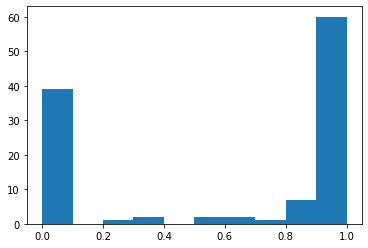

In [330]:
plt.hist(pred_proba[:, 1])